# MiniGato

From the paper [A Generalist Agent](https://arxiv.org/abs/2205.06175).

The paper doesn't introduce a new architecture. Instead, the paper is all about tokenizing, embedding, and sequencing data from multiple modalities (text, image, proprioception) in such a way that it can be learned by a transformer.

Reproducing the paper is more of a software design exercise than an ML research exercise. How would you structure the data manipulation code – the tokenization, embedding, and sequencing of different modalities – in a way that's correct, easy to understand and extend, and performant?

## Imports

Just grouping and hiding these to avoid noise.

In [1]:
import mini_gato
import mini_gato.util
import importlib
importlib.reload(mini_gato.util)

<module 'mini_gato.util' from '/home/eihli/src/mini_gato/mini_gato/util.py'>

In [2]:
from collections import OrderedDict
from itertools import cycle
import math
import pdb
import random
from typing import List
from dataclasses import dataclass, fields
import datasets
from einops import rearrange
from functools import partial
from mini_gato.nano_gpt import GPT, GPTConfig
import numpy as np
import matplotlib.pyplot as plt
import minari
from mini_gato.util import (
    tensor_as_gif, TransformDataset,
    images_to_patches, patches_to_images, normalize_to_between_minus_one_plus_one,
    apply_along_dimension, mu_law_decode, mu_law_encode,
    interleave, deinterleave,
)
import minigrid.core
from timm.models.resnetv2 import ResNetV2
import tiktoken
import torch
import torch.nn.functional as F
import torchvision.transforms.v2 as transforms
from torchvision.transforms.functional import pil_to_tensor
from torch.utils.data import Dataset, DataLoader

In [3]:
# Interleave tensors a, b, and c, such that
# the result is `[[1, 2, 3, 9, 8, 7, 5, 5, 5, 5], [4, 5, 6, 9, 8, 7, 6, 5, 4, 6, 6, 6, 6], ...]
a = torch.tensor([[1, 2, 3], [4, 5, 6]])
b = torch.tensor([[9, 8, 7], [6, 5, 4]])
c = torch.tensor([[5, 5, 5, 5], [6, 6, 6, 6]])

## Tokenization [§ 2.1](https://arxiv.org/pdf/2205.06175)

> There are infinite possible ways to transform data into tokens, including directly using the raw underlying byte stream.

We're going to start off with a certain set of tokenization strategies for a certain set of modalities. We might want to expand that in the future. When that happens, I don't want to have to edit code in the PyTorch Module that implements our model code. I'd rather be able to add a new class of modality that implements a "tokenization" signature.

#### Example

In [4]:
four_rooms_dataset = minari.load_dataset('D4RL/minigrid/fourrooms-v0', download=True)

In [5]:
four_rooms_dataset[0]

EpisodeData(id=0, total_steps=19, observations={direction: ndarray of shape (20,) and dtype int64, image: ndarray of shape (20, 7, 7, 3) and dtype uint8, mission: ['reach the goal', 'reach the goal', 'reach the goal', 'reach the goal', 'reach the goal', 'reach the goal', 'reach the goal', 'reach the goal', 'reach the goal', 'reach the goal', 'reach the goal', 'reach the goal', 'reach the goal', 'reach the goal', 'reach the goal', 'reach the goal', 'reach the goal', 'reach the goal', 'reach the goal', 'reach the goal']}, actions=ndarray of shape (19,) and dtype int64, rewards=ndarray of 19 floats, terminations=ndarray of 19 bools, truncations=ndarray of 19 bools, infos=dict with the following keys: [])

## Modality

In [6]:
@dataclass
class Modality:
    origin: any
    tokens: torch.Tensor
    targets: torch.Tensor
    attention_mask: torch.Tensor
    embeddings: torch.Tensor = torch.tensor([])

    def __repr__(self):
        return f"{type(self).__name__}(\n\t{self.origin!r}\n\t{self.tokens!r}\n\t{self.targets!r}\n\t{self.attention_mask!r}\n\t{self.embeddings!r}\n)"
        
    def size(self, *args, **kwargs):
        return self.tokens.size(*args, **kwargs)

    def to(self, device):
        """Return new instance of class with all fields moved to device."""
        return type(self)(
            tokens=type(self.tokens)(self.tokens.to(device)),
            targets=type(self.targets)(self.targets.to(device)),
            attention_mask=type(self.attention_mask)(self.attention_mask.to(device)),
            embeddings=type(self.embeddings)(self.embeddings.to(device)),
        )

    def clone(self):
        return type(self)(
            tokens=type(self.tokens)(self.tokens.clone()),
            targets=type(self.targets)(self.targets.clone()),
            attention_mask=type(self.attention_mask)(self.attention_mask.clone()),
            embeddings=type(self.embeddings)(self.embeddings.clone()),
        )

In [7]:
Modality('foo', torch.tensor(1), torch.tensor(2), torch.tensor(3))

Modality(
	'foo'
	tensor(1)
	tensor(2)
	tensor(3)
	tensor([])
)

## Series

In [8]:
@dataclass
class Series:
    def __len__(self):
        #       number of episodes * number of tokens per episode
        return sum(getattr(self, field.name).tokens.size(0) * getattr(self, field.name).tokens.size(1) for field in fields(self))

    def n_modalities(self):
        return len(fields(self))

@dataclass
class FourRoomsSeries(Series):
    mission: Modality
    direction: Modality
    image: Modality
    action: Modality

@dataclass
class GenericVQASeries(Series):
    question: Modality
    image: Modality
    answer: Modality

@dataclass
class GenericTextSeries(Series):
    text: Modality

Sweet. Now we can index into a series as if it were sequenced.

## Tokenization

In [9]:
from collections import defaultdict

In [10]:
def pad_tokens(batch, padding_value=0):
    padded = defaultdict(list)    
    for k, v in batch[0].items():
        max_tokens = max([sample[k].size(1) for sample in batch])
        for sample in batch:
            if len(sample[k].shape) == 2:
                pad = (0, max_tokens - sample[k].size(1), 0, 0)
            else:
                pad = (0, 0, 0, max_tokens - sample[k].size(1), 0, 0)
            padded[k].append(F.pad(sample[k], pad, value=0))
    results = []
    for _ in range(len(batch)):
        results.append({})
    for k, vs in padded.items():
        for i in range(len(batch)):               
            results[i][k] = padded[k][i]
    return results

def pad_sequence(batch, sequence_length=1024, padding_value=0):
    padded = defaultdict(list)
    for k, v in batch[0].items():
        for sample in batch:
            if len(sample[k].shape) == 2:
                pad = (0, 0, 0, sequence_length - sample[k].size(0))
            else:
                pad = (0, 0, 0, 0, 0, sequence_length - sample[k].size(0))
            padded[k].append(F.pad(sample[k], pad, value=0))
    results = []
    for _ in range(len(batch)):
        results.append({})
    for k, vs in padded.items():
        for i in range(len(batch)):
            results[i][k] = padded[k][i]
    return results

def mask(batch):
    if len(batch) == 0:
        return []
    result = {}
    for k, v in batch[0].items():
        n_episodes = [sample[k].size(0) for sample in batch]
        n_tokens = [sample[k].size(1) for sample in batch]
        result[k] = torch.zeros(len(batch), max(n_episodes), max(n_tokens))
        for i in range(result[k].size(0)):
            result[k][i][:n_episodes[i], :n_tokens[i]] = 1
    return result

batch = [
    {
        'mission': torch.arange(2*3).view(2, 3),
        'image': torch.randn(2*7*7*3).view(2, 7, 7, 3),
    },
    {
        'mission': torch.arange(3*4).view(3, 4),
        'image': torch.randn(2*7*7*3).view(2, 7, 7, 3),
    },
]

padded = pad_tokens(batch)
padded = pad_sequence(padded, sequence_length=3)
masked = mask(batch)

In [11]:
[p['mission'] for p in padded], masked

([tensor([[0, 1, 2, 0],
          [3, 4, 5, 0],
          [0, 0, 0, 0]]),
  tensor([[ 0,  1,  2,  3],
          [ 4,  5,  6,  7],
          [ 8,  9, 10, 11]])],
 {'mission': tensor([[[1., 1., 1., 0.],
           [1., 1., 1., 0.],
           [0., 0., 0., 0.]],
  
          [[1., 1., 1., 1.],
           [1., 1., 1., 1.],
           [1., 1., 1., 1.]]]),
  'image': tensor([[[1., 1., 1., 1., 1., 1., 1.],
           [1., 1., 1., 1., 1., 1., 1.]],
  
          [[1., 1., 1., 1., 1., 1., 1.],
           [1., 1., 1., 1., 1., 1., 1.]]])})

In [12]:
padded[0].keys()

dict_keys(['mission', 'image'])

In [13]:
class Tokenizer:
    TEXT = 0
    IMAGE = 1
    DISCRETE = 2
    CONTINUOUS = 3

    def __init__(self, text_tokenizer):
        self.text_tokenizer = text_tokenizer
        self.n_text = text_tokenizer.n_vocab
        self.n_discrete = 1024
        self.eod_token = 1023
        self.n_modalities = 1024
        self.modalities = torch.arange(self.n_modalities) + self.n_text + self.n_discrete

    def encode_text(self, text):
        return self.modalities[self.TEXT].unsqueeze(0), torch.tensor(self.text_tokenizer.encode(text))

    def decode_text(self, tokens):
        if isinstance(tokens, torch.Tensor):
            tokens = tokens.tolist()
        return self.text_tokenizer.decode(tokens)

    def encode_discrete(self, discrete):
        return self.modalities[self.DISCRETE].unsqueeze(0), torch.tensor([discrete + self.n_text])

    def decode_discrete(self, tokens):
        if isinstance(tokens, torch.Tensor):
            tokens = tokens.tolist()
        return tokens - self.n_text

    def encode_image(self, image, patch_size=16):
        patches = images_to_patches(image, patch_size=patch_size)
        xs = (
            apply_along_dimension(
                normalize_to_between_minus_one_plus_one, 1, patches
            )
            / math.sqrt(patch_size)
        )
        return self.modalities[self.IMAGE].unsqueeze(0), xs

    def decode_image(self, tokens, image_shape=(3, 192, 192), patch_size=16):
        # Lossy because I'm not saving the values used for scaling from encoding.
        patches = (tokens * math.sqrt(patch_size) + 1) / 2
        images = patches_to_images(patches, image_shape, patch_size=patch_size)
        return images

    def is_text(self, cls):
        return (cls[cls.nonzero(as_tuple=True)] == self.modalities[self.TEXT]).all().item()

    def is_image(self, cls):
        return (cls[cls.nonzero(as_tuple=True)] == self.modalities[self.IMAGE]).all().item()

    def is_discrete(self, cls):
        return (cls[cls.nonzero(as_tuple=True)] == self.modalities[self.DISCRETE]).all().item()

    def is_continuous(self, cls):
        return (cls[cls.nonzero(as_tuple=True)] == self.modalities[self.CONTINUOUS]).all().item()
    

In [14]:
text_encoding = tiktoken.get_encoding("r50k_base")
tokenizer = Tokenizer(text_encoding)

In [15]:
tokenizer.encode_text('hello, world')

(tensor([51281]), tensor([31373,    11,   995]))

## Image prep

In [16]:
normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
denormalize = transforms.Normalize([-0.485/0.229, -0.456/0.224, -0.406/0.255], [1/0.229, 1/0.224, 1/0.225])

In [17]:
image_transform = transforms.Compose([
    transforms.ToDtype(torch.float32, scale=True),
    transforms.RandomResizedCrop((192, 192), (1.0, 1.0)),
    normalize,
])

## Datasets

In [18]:
SEQUENCE_LENGTH = 1024

In [19]:
def episode_num_tokens(sample):
    return sum([len(v[0]) for v in sample.values()])

def sample_num_tokens(sample):
    return episode_num_tokens(sample) * next(iter(sample.values())).size(0)

def sequence_episode_capacity(sequence_length, sample):
    return sequence_length // episode_num_tokens(sample)

def random_episode_start_index(sequence_length, sample):
    cap = sequence_episode_capacity(sequence_length, sample)
    return random.randint(0, cap)

def slice_to_context_window(sequence_length, sample):
    result = OrderedDict()
    n = random_episode_start_index(1024, sample)
    m = sequence_episode_capacity(1024, sample)
    for k in sample.keys():
        result[k] = sample[k][n:n+m]
    return result

In [20]:
four_rooms_dataset = minari.load_dataset('D4RL/minigrid/fourrooms-v0', download=True)

In [21]:
# Some FourRooms/Minigrid-specific stuff to turn
# a 7x7x3 non-pixel observation into an pixel/image observation.
lut = np.zeros((256, 3), dtype=np.uint8)
for idx, color_name in minigrid.core.constants.IDX_TO_COLOR.items():
    lut[idx] = minigrid.core.constants.COLORS[color_name]

def four_rooms_to_rgb(images):
    """Convert discrete "image" observations into actual images.
    I'm expecting this will improve our image modality while not losing
    much. The downside is we can fit less in our context window. Note:
    We might need to overlay the color/type image (index 1) with the
    state image (index 2), if we really don't want to lose any info."""
    # Apply lookup to second channel
    return torch.from_numpy(lut[images[:, :, :, 1]]).permute(0, 3, 1, 2)    

def tokenize_four_rooms(tokenizer, episode):
    mission_cls, mission_tokens = zip(*[tokenizer.encode_text(mission) for mission in episode.observations["mission"]])
    direction_cls, direction_tokens = zip(*[tokenizer.encode_discrete(direction) for direction in episode.observations["direction"]])
    image = episode.observations["image"]
    image = four_rooms_to_rgb(image)
    image_cls, image_tokens = zip(*[tokenizer.encode_image(image) for image in image_transform(image)])
    action_cls, action_tokens = zip(*[tokenizer.encode_discrete(action) for action in episode.actions])
    return OrderedDict({
        'mission_cls': torch.stack(mission_cls[:-1]),
        'mission': torch.stack(mission_tokens[:-1]),
        'direction_cls': torch.stack(direction_cls[:-1]),
        'direction': torch.stack(direction_tokens[:-1]), 
        'image_cls': torch.stack(image_cls[:-1]),
        'image': torch.stack(image_tokens[:-1]),
        'action_cls': torch.stack(action_cls),
        'action': torch.stack(action_tokens),
    })

def four_rooms_collate_fn(batch, sequence_length=1024):
    batch = [slice_to_context_window(sequence_length, sample) for sample in batch]
    padded = pad_tokens(batch)
    padded = pad_sequence(batch, sequence_length=sequence_length)
    masked = mask(batch)
    return padded, masked

In [22]:
four_rooms_dataset_xf = TransformDataset(four_rooms_dataset, partial(tokenize_four_rooms, tokenizer))

In [23]:
vqa_dataset = datasets.load_dataset("eihli/micro-ok-vqa")

In [24]:
img = image_transform(pil_to_tensor(vqa_dataset['train'][0]['image']))

In [25]:
image_cls, image_tokens = zip(*[tokenizer.encode_image(image) for image in [img, img]])

In [26]:
torch.stack(image_cls), torch.stack(image_tokens).shape

(tensor([[51282],
         [51282]]),
 torch.Size([2, 144, 768]))

In [27]:
four_rooms_dataset_xf[0]['image_cls'].shape

torch.Size([19, 1])

In [28]:
four_rooms_dataset_xf[0]['mission'].shape

torch.Size([19, 3])

In [29]:
batch = [four_rooms_dataset_xf[i] for i in range(4)]

In [30]:
four_rooms_collate_fn(batch)[1]['image'].shape, four_rooms_collate_fn(batch)[1]['direction_cls'].shape

(torch.Size([4, 6, 144]), torch.Size([4, 6, 1]))

In [31]:
batch = four_rooms_collate_fn(batch)

In [80]:
batch[0][0]['mission'].shape

torch.Size([1024, 3])

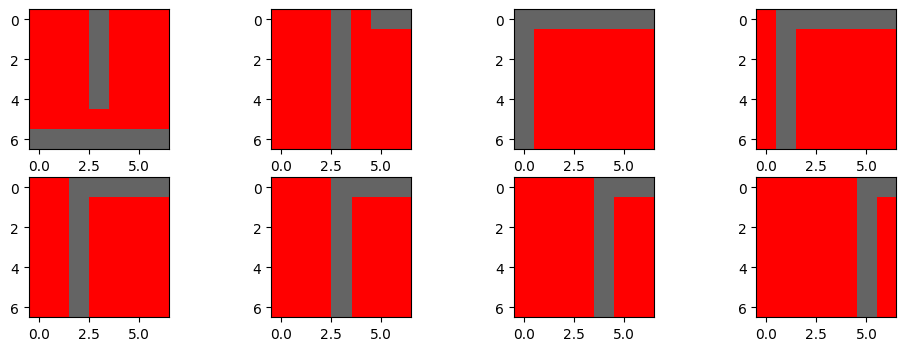

In [33]:
fig, axs = plt.subplots(2, 4, figsize=(12, 4))
for i in range(2):
    for j in range(4):
        axs[i][j].imshow(four_rooms_to_rgb(four_rooms_dataset[0].observations['image'][[i*4+j]])[0].permute(1, 2, 0))

In [34]:
four_rooms_dataset[0].observations['image'][[i]].shape

(1, 7, 7, 3)

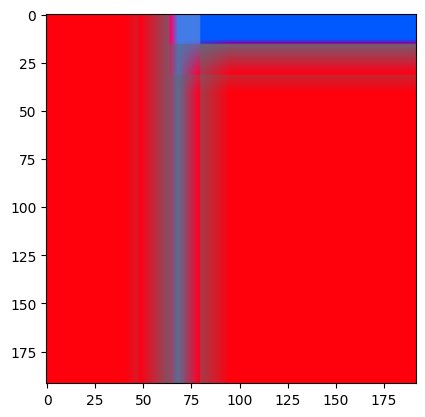

In [35]:
patches = four_rooms_dataset_xf[0]['image']
plt.imshow(tokenizer.decode_image(patches).permute(0, 2, 3, 1)[4])

In [36]:
patches = four_rooms_dataset_xf[0]['image']
tokenizer.decode_image(patches);

In [37]:
B, T, C = four_rooms_dataset_xf[0]['image'].shape

In [38]:
four_rooms_dataset_xf[0]['image'].reshape(B, T, 3, 16, 16).shape

torch.Size([19, 144, 3, 16, 16])

In [39]:
tokenizer.decode_image(four_rooms_dataset_xf[0]['image']).shape

torch.Size([19, 3, 192, 192])

# Demo

In [40]:
four_rooms_dataset[0].observations['image'].shape
# 20 "episodes" (or "steps" that the robot took to complete the task)
# 7x7 grid of vision at each step
# 3 "channels". NOT RGB. (object_type, object_color, object_state)

(20, 7, 7, 3)

In [41]:
images = four_rooms_to_rgb(four_rooms_dataset[0].observations['image'])
images.shape, images[0]

(torch.Size([20, 3, 7, 7]),
 tensor([[[255, 255, 255, 100, 255, 255, 255],
          [255, 255, 255, 100, 255, 255, 255],
          [255, 255, 255, 100, 255, 255, 255],
          [255, 255, 255, 100, 255, 255, 255],
          [255, 255, 255, 100, 255, 255, 255],
          [255, 255, 255, 255, 255, 255, 255],
          [100, 100, 100, 100, 100, 100, 100]],
 
         [[  0,   0,   0, 100,   0,   0,   0],
          [  0,   0,   0, 100,   0,   0,   0],
          [  0,   0,   0, 100,   0,   0,   0],
          [  0,   0,   0, 100,   0,   0,   0],
          [  0,   0,   0, 100,   0,   0,   0],
          [  0,   0,   0,   0,   0,   0,   0],
          [100, 100, 100, 100, 100, 100, 100]],
 
         [[  0,   0,   0, 100,   0,   0,   0],
          [  0,   0,   0, 100,   0,   0,   0],
          [  0,   0,   0, 100,   0,   0,   0],
          [  0,   0,   0, 100,   0,   0,   0],
          [  0,   0,   0, 100,   0,   0,   0],
          [  0,   0,   0,   0,   0,   0,   0],
          [100, 100, 100, 

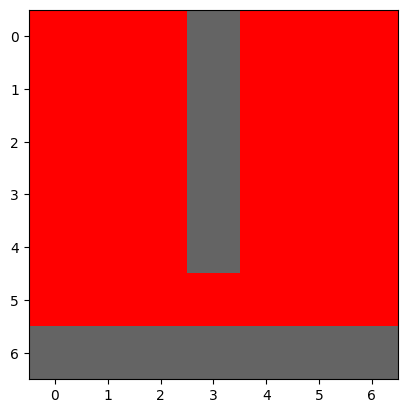

In [42]:
plt.imshow(images[0].permute(1, 2, 0))

In [43]:
from PIL import Image
from IPython.display import display, Image as IPythonImage

In [44]:
# Converting them to PIL Images gives us a convenient way to save the images as a GIF.
images = four_rooms_to_rgb(four_rooms_dataset[0].observations['image'])
images = images.permute(0, 2, 3, 1).numpy()
images = [Image.fromarray(image) for image in images]
images[:3]

[<PIL.Image.Image image mode=RGB size=7x7>,
 <PIL.Image.Image image mode=RGB size=7x7>,
 <PIL.Image.Image image mode=RGB size=7x7>]

In [45]:
# And when you think "save as" you usually think "files".
with open("/tmp/foo.gif", "wb") as f:
    images[0].save(
        f,
        format='GIF',
        save_all=True,
        append_images=images[1:],
        duration=200,
        loop=0,
    )

In [46]:
# And that usually means making things OS-agnostic.
import os
import tempfile
temp_dir = tempfile.gettempdir()
temp_file_path = os.path.join(temp_dir, 'foo.gif')
with open(temp_file_path, "wb") as f:
    images[0].save(
        f,
        format='GIF',
        save_all=True,
        append_images=images[1:],
        duration=200,
        loop=0,
    )

In [47]:
with open("/tmp/foo.gif", "rb") as f:
    display(IPythonImage(f.read()))

In [48]:
with open("/tmp/foo.gif", "rb") as f:
    display(IPythonImage(f.read(), width=192, height=192))

In [49]:
import io
# But there's a better way!
buffer = io.BytesIO()
images[0].save(
    buffer,
    format='GIF',
    save_all=True,
    append_images=images[1:],
    duration=200,
    loop=0,
)
buffer.seek(0)
display(IPythonImage(data=buffer.getvalue(), width=192, height=192))

In [50]:
four_rooms_dataloader = DataLoader(four_rooms_dataset_xf, batch_size=4, collate_fn=four_rooms_collate_fn)

In [51]:
batch = next(iter(four_rooms_dataloader))

In [52]:
batch[0][0]['mission'].shape

torch.Size([1024, 3])

In [53]:
vqa_dataset = datasets.load_dataset("eihli/micro-ok-vqa")

In [54]:
def tokenize_vqa(tokenizer, sample):
    question_cls, question = zip(*[tokenizer.encode_text(sample["question"])])
    image_cls, image = zip(*[tokenizer.encode_image(image_transform(pil_to_tensor(sample["image"])))])
    answer_cls, answer = zip(*[tokenizer.encode_text(random.choice(sample["answers"])["answer"])])
    return OrderedDict({
        'question_cls': torch.stack(question_cls),
        'question': torch.stack(question),
        'image_cls': torch.stack(image_cls),
        'image': torch.stack(image),
        'answer_cls': torch.stack(answer_cls),
        'answer': torch.stack(answer),
    })

def vqa_collate_fn(batch):
    padded = pad_tokens(batch)
    masked = mask(batch)
    return padded, masked

In [55]:
sample = vqa_dataset['train'][0]

In [56]:
cls, tokens = tokenizer.encode_image(image_transform(pil_to_tensor(sample["image"])))

In [57]:
cls, tokens

(tensor([51282]),
 tensor([[-0.2378, -0.2437, -0.2390,  ...,  0.1854,  0.1832,  0.1849],
         [-0.2446, -0.2466, -0.2453,  ...,  0.2264,  0.2325,  0.2391],
         [-0.1818, -0.1153, -0.0956,  ...,  0.2149,  0.2101,  0.2130],
         ...,
         [ 0.0385,  0.0600,  0.0706,  ...,  0.2237,  0.2288,  0.2367],
         [ 0.0707,  0.0894,  0.1001,  ...,  0.2478,  0.2362,  0.0630],
         [-0.0377, -0.0938, -0.1630,  ...,  0.1883,  0.1839,  0.1875]]))

In [58]:
vqa_dataset_xf = TransformDataset(vqa_dataset["train"], partial(tokenize_vqa, tokenizer))

In [59]:
sample = four_rooms_dataset_xf[0]

In [60]:
series = vqa_dataset_xf[0]
series['question'].shape, series['image'].shape, tokenizer.decode_text(series['answer'][0].tolist()), tokenizer.decode_text(series['question'][0].tolist())

(torch.Size([1, 10]),
 torch.Size([1, 144, 768]),
 'pony tail',
 'What is the hairstyle of the blond called?')

## Embedding

In [61]:
EMBEDDING_DIMS = 512

In [62]:
image_embedding = ResNetV2(layers=[3, 4, 6, 3], num_classes=EMBEDDING_DIMS)
lookup_embedding = torch.nn.Embedding(tokenizer.n_text + tokenizer.n_discrete + tokenizer.n_modalities, EMBEDDING_DIMS)

In [63]:
sample = four_rooms_dataset_xf[0]

In [64]:
image_tokens = sample['image']
image_tokens.shape

torch.Size([19, 144, 768])

In [65]:
B, T, C = image_tokens.shape
patch_size=16

In [66]:
patch_tokens = image_tokens.view(B*T, 3, patch_size, patch_size)
patch_embeddings = image_embedding(patch_tokens).view(B, T, -1)

In [67]:
mission_tokens = sample['mission']
mission_tokens.shape

torch.Size([19, 3])

In [68]:
mission_embeddings = lookup_embedding(mission_tokens)
mission_embeddings.shape

torch.Size([19, 3, 512])

In [69]:
from typing import Callable
@dataclass
class Embedder:
    tokenizer: Tokenizer
    lookup_embedding: Callable
    image_embedding: Callable

    def embed(self, cls, data):
        if self.tokenizer.is_image(cls):
            B, T, P, C = data.shape
            return torch.concat([self.lookup_embedding(cls.view(B*T, 1)).view(B, T, 1, -1), self.image_embedding(data.view(B*T*P, 3, 16, 16)).view(B, T, P, -1)], dim=2)
        else:
            B, T, C = data.shape
            return torch.concat([self.lookup_embedding(cls.view(B*T, 1)).view(B, T, 1, -1), self.lookup_embedding(data.view(B*T, C)).view(B, T, C, -1)], dim=2)

In [77]:
len(batch), type(batch[0]), len(batch[0][0]), batch[0][0]['direction'].shape

(2, list, 8, torch.Size([1024, 1]))

In [70]:
B, T, C = batch[0]['direction'].shape
lookup_embedding(batch[0]['direction'].view(B*T, C)).view(B, T, -1).shape

TypeError: list indices must be integers or slices, not str

In [71]:
embedder = Embedder(tokenizer, lookup_embedding, image_embedding)

In [ ]:
series = batch[0]

In [ ]:
vals = list(series.values())
for cls, data in zip(vals[::2], vals[1::2]):
    print(cls.shape, data.shape)

In [ ]:
lookup_embedding(cls).shape, lookup_embedding(data).shape

In [ ]:
cls.shape, data.shape

In [ ]:
embeddings = [embedder.embed(cls, data) for cls, data in zip(vals[::2], vals[1::2])]

In [269]:
B, T, C = 4, 2, 8
a = torch.arange(B*T*C*3)
b = torch.arange(B*T*C*4)

In [270]:
[e.shape for e in embeddings]

NameError: name 'embeddings' is not defined

In [271]:
batch = torch.concat([e for e in embeddings], dim=2)
batch.shape

NameError: name 'embeddings' is not defined

In [272]:
B, T, S, C = batch.shape
B*T*S


AttributeError: 'tuple' object has no attribute 'shape'

In [273]:
transformer_config = GPTConfig(n_head=8, n_embd=512)
gpt = GPT(transformer_config)

number of parameters: 63.59M


In [274]:
gpt.config.n_embd

512

In [275]:
@dataclass
class MiniGatoConfig:
    embedding_dim: int
    sequence_length: int
    tokenizer: Tokenizer
    transformer_config: GPTConfig
    transformer: GPT

def init_default_config() -> MiniGatoConfig:
    transformer_config = GPTConfig(n_head=8, n_embd=512)
    text_encoding = tiktoken.get_encoding("r50k_base")
    tokenizer = Tokenizer(text_encoding)
    return MiniGatoConfig(
        embedding_dim=512,
        sequence_length=1024,
        tokenizer=tokenizer,
        transformer_config=transformer_config,
        transformer=GPT(transformer_config),
    )

default_config = init_default_config()

class MiniGato(torch.nn.Module):
    def __init__(self, config: MiniGatoConfig=default_config):
        super().__init__()
        self.config = config
        self.tokenizer = config.tokenizer
        self.sequence_length = self.config.sequence_length
        self.image_embedding = ResNetV2(layers=[3, 4, 6, 3], num_classes=EMBEDDING_DIMS)
        self.lookup_embedding = torch.torch.nn.Embedding(self.tokenizer.n_text + self.tokenizer.n_discrete + self.tokenizer.n_modalities, EMBEDDING_DIMS)
        self.embedder = Embedder(
            config.tokenizer,
            lookup_embedding,
            image_embedding,
        )
        self.transformer = self.config.transformer
        self.lm_head = torch.nn.Linear(self.transformer.config.n_embd, self.tokenizer.n_text + self.tokenizer.n_discrete + self.tokenizer.n_modalities)    

    def forward(self, batch, targets=None):
        vals = list(series.values())
        embeddings = [embedder.embed(cls, data) for cls, data in zip(vals[::2], vals[1::2])]
        batch = torch.concat(embeddings, dim=2)
        B, T, S, C = batch.shape
        out, _ = self.transformer(emb=batch.view(B*T*S, C))
        if targets is not None:
            logits = self.lm_head(out.last_hidden_state)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)
        else:
            predicted = self.lm_head(out.last_hidden_state)
        return predicted, ys, ms

number of parameters: 63.59M


In [276]:
def infinite_dataloader(fn):
    it = iter(fn())
    while True:
        try:
            yield next(it)
        except StopIteration:
            it = iter(fn())

In [277]:
BATCH_SIZE=4

In [278]:
dataloaders = [
    infinite_dataloader(partial(DataLoader, four_rooms_dataset_xf, batch_size=BATCH_SIZE, collate_fn=four_rooms_collate_fn)),
    infinite_dataloader(partial(DataLoader, vqa_dataset_xf, batch_size=BATCH_SIZE, collate_fn=vqa_collate_fn)),
]
dl_it = cycle(dataloaders)

In [279]:
len(vqa_dataset["train"])

80

In [80]:
config = init_default_config()
model = MiniGato(config)

number of parameters: 63.59M


In [81]:
dl = next(dl_it)
batch = next(dl)

In [82]:
embed_image = ResNetV2(layers=[3, 4, 6, 3], num_classes=EMBEDDING_DIMS)
embed_text = torch.torch.nn.Embedding(tokenizer.n_text, EMBEDDING_DIMS)
embed_discrete = torch.torch.nn.Embedding(tokenizer.n_discrete, EMBEDDING_DIMS)
embedder = Embedder(tokenizer, lookup_embedding, image_embedding)

In [83]:
optimizer = torch.optim.AdamW(model.parameters())

In [84]:
len(batch[0].values())

8

In [85]:
sample = batch[0]
vals = list(sample.values())
[v.shape for v in vals]
embeddings = [embedder.embed(cls, data) for cls, data in zip(vals[::2], vals[1::2])]

In [86]:
optimizer.zero_grad()
predicted, targets, attention_mask = model(batch)

ValueError: not enough values to unpack (expected 3, got 2)

In [ ]:
model.train()
for i in tqdm(range(self.num_iterations)):
    dl = next(dl_it)
    batch = next(dl)
    optimizer.zero_grad()
    predicted, targets, attention_mask = model(batch)
    self.losses.append(loss.item())
    loss.backward()
    if self.scheduler:
        self.scheduler.step()
    self.optimizer.step()